In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving FReD-2024-11-29_cleaned.csv to FReD-2024-11-29_cleaned.csv


In [ ]:
data = pd.read_csv('FReD-2024-11-29_cleaned.csv')
data.head()

,es_original,n_original,p_value_original,vi_original,result,ci.lower_original,ci.upper_original,disc_cognitive_psychology,disc_developmental_psychology,disc_experimental_philosophy,...,tag_self-determination_theory,tag_media_psychology,tag_well-being,tag_brand_names,tag_linguistics,tag_sound_symbolism,tag_social_value_orientation_(slm),tag_sample_2,tag_social_value_orientation_(tdm),tag_sample_1
0,0.205737,133.0,0.017513,0.006948,Failure,0.036799,0.363242,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.274010,71.0,0.020760,0.012221,Failure,0.043486,0.476831,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.516812,40.0,0.000639,0.013773,Success,0.244697,0.713460,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.344313,28.0,0.072784,0.028776,OS not significant,-0.033003,0.635727,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.445653,24.0,0.029070,0.027923,Success,0.051517,0.719671,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
unique_values = data['result'].unique()
print(unique_values)

['Failure' 'Success' 'OS not significant' 'Failure (reversal)']


In [ ]:
value_counts = data['result'].value_counts()
print(value_counts)

result
Success               207
Failure               190
OS not significant     93
Failure (reversal)      4
Name: count, dtype: int64


In [ ]:
data = data[data['result'] != "OS not significant"]
data = data[data['result'] != "Failure (reversal)"]

In [ ]:
value_counts = data['result'].value_counts()
print(value_counts)

result
Success    207
Failure    190
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
X = data.drop('result', axis=1)
y = data['result']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.625
Classification Report:
              precision    recall  f1-score   support

     Failure       0.57      0.64      0.61        36
     Success       0.68      0.61      0.64        44

    accuracy                           0.62        80
   macro avg       0.62      0.63      0.62        80
weighted avg       0.63      0.62      0.63        80



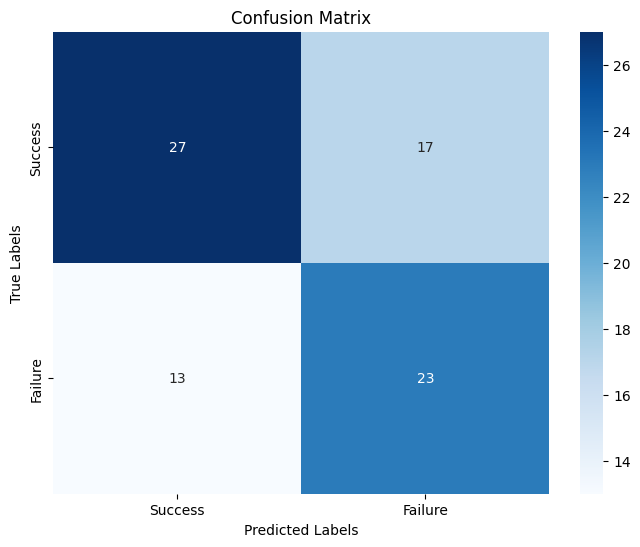

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=["Success", "Failure"])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Success", "Failure"], yticklabels=["Success", "Failure"])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
print(feature_importances.sort_values(by='Importance', ascending=False))

                               Feature  Importance
4                    ci.lower_original    0.141232
3                          vi_original    0.128402
0                          es_original    0.121817
2                     p_value_original    0.119360
5                    ci.upper_original    0.116815
..                                 ...         ...
41         tag_psychomotor_performance    0.001168
21                      tag_short-term    0.001079
58  tag_social_value_orientation_(slm)    0.000000
60  tag_social_value_orientation_(tdm)    0.000000
14           tag_conflict_(psychology)    0.000000

[62 rows x 2 columns]


## Grid Search for tuning hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

Fitting 3 folds for each of 216 candidates, totalling 648 fits


In [ ]:
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Accuracy: 0.6845462713387241


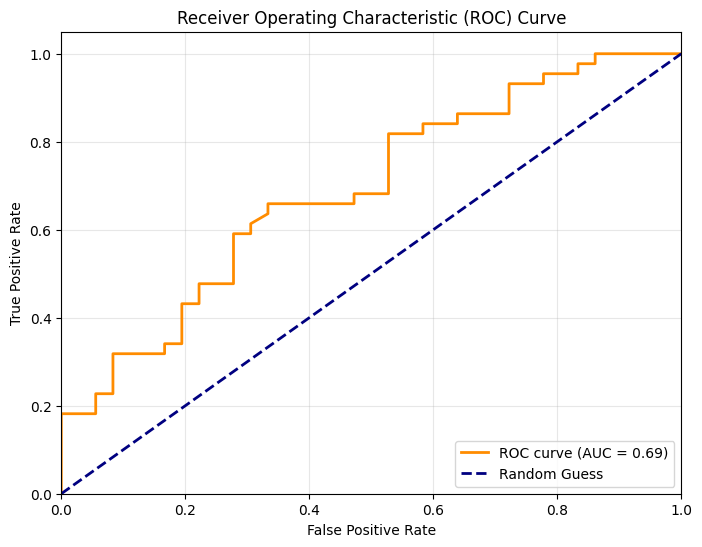

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

y_test_proba = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba, pos_label="Success")
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.65
Classification Report:
              precision    recall  f1-score   support

     Failure       0.60      0.67      0.63        36
     Success       0.70      0.64      0.67        44

    accuracy                           0.65        80
   macro avg       0.65      0.65      0.65        80
weighted avg       0.65      0.65      0.65        80

